# Driver Analysis
This notebook compares the top 3 drivers in the World Drivers' Championship as of 21 races finished in the 2024 season:
- Max Verstappen (VER): Red Bull Racing
- Lando Norris (NOR): McLaren
- Charles Leclerc (LEC): Ferrari

*This analysis uses data from FastF1 API*

In [1]:
# !pip install fastf1
# !pip install seaborn

In [1]:
from core.extract import F1DataProcessor
from core.telemetry import F1TelemetryAnalyzer
from core.dpi import F1DriverPerformanceIndex
from core.utils import plot_combined_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import fastf1

# %load_ext autoreload
# %autoreload 2

## Qualifying Performance
We use two datasets here `quali_data` and `quali_telemetry`.
1. `quali_data` contains general information about laps done in qualifying sessions taken from `session.laps` endpoint
2. `quali_telemetry` contains telemetry data about each lap done in qualifying sessions (standardized to have 300 data points per lap) taken from `get_car_data()` endpoint

A Grand Prix qualifying session determines the grid order for Sunday Grand Prix races, and is broken down into three further sessions: Q1, Q2, Q3. Five drivers are knocked out after each Qualifying session, with Q3 being a top-10 shootout for pole position (position 1 on the grid).
<br>
<br>
**quali_data**
- Most of the information in this dataframe is already given by `session.laps` endpoint
- Transformations done: <br>
     (1) Converted `SectorTime` to total seconds<br>
     (2) Added `LapEndDate` to extract accurate corresponding telemetry data<br>
     (3) Added `QualiSession` to determine which qualifying session the lap was set (only fast laps* are considered)<br>
     (4) Added `LapRank` which is the driver's lap's rank at the time of setting it<br>
     (5) Added `DeltaFastestLap` which is the driver's lap's difference from the fastest lap at the time of setting it<br>

**quali_telemetry**
- Most of the information in this dataframe is already given by `get_car_data` endpoint
- Added identifier columns to merge with `quali_data` (`Round`, `Driver`, `LapNumber`)


*Fast laps are considered the driver's best attempt (no warm-up laps or cool down laps)

In [3]:
# Define custom cache directory
cache_dir = r"C:\Enzo_Files\AIM Data Science"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

# Initialize processor with the same path
processor = F1DataProcessor(cache_dir=cache_dir, year=2024)

# Get normalized qualifying data

quali_data, quali_telemetry = processor.get_quali_session(
    # rounds=range(1, 22),
    rounds=range(1, 3), # 22 races total
    drivers=["VER", "NOR", "LEC", "PIA"],
    normalize_telemetry=True, 
    target_points=300
)

In [4]:
# looks like all data
quali_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,QualiSession,LapRank,CurrentFastestLap,DeltaFastestLap,Position
18,1,LEC,16,Ferrari,0 days 00:01:31.260000,2.0,1.0,29.522,39.009,22.729,...,1,False,,2024-03-01 16:02:12.510,2024-03-01 16:03:43.770,1.0,2.0,0 days 00:01:31.208000,0.052,2.0
118,1,PIA,81,McLaren,0 days 00:01:30.692000,2.0,1.0,29.243,38.780,22.669,...,1,False,,2024-03-01 16:08:14.593,2024-03-01 16:09:45.285,1.0,2.0,0 days 00:01:30.623000,0.069,8.0
103,1,NOR,4,McLaren,0 days 00:01:30.143000,2.0,1.0,28.983,38.576,22.584,...,1,False,,2024-03-01 16:08:33.263,2024-03-01 16:10:03.406,1.0,1.0,0 days 00:01:30.143000,0.000,7.0
1,1,VER,1,Red Bull Racing,0 days 00:01:30.031000,2.0,1.0,28.787,38.580,22.664,...,1,False,,2024-03-01 16:08:56.653,2024-03-01 16:10:26.684,1.0,1.0,0 days 00:01:30.031000,0.000,1.0
21,1,LEC,16,Ferrari,0 days 00:01:30.243000,5.0,2.0,29.067,38.589,22.587,...,1,False,,2024-03-01 16:09:51.898,2024-03-01 16:11:22.141,1.0,5.0,0 days 00:01:30.031000,0.212,2.0


In [5]:
quali_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,0 days 00:00:00.107000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,0 days 00:00:00.292418060,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,0 days 00:00:00.507668896,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,0 days 00:00:00.688384615,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,0 days 00:00:00.970501672,1,VER,1


In [6]:
quali_data.groupby(["Driver", "QualiSession"]).LapRank.mean()

Driver  QualiSession
LEC     1.0             16.500000
        2.0              2.250000
        3.0              2.400000
NOR     1.0             12.400000
        2.0              7.600000
        3.0              3.500000
PIA     1.0              9.500000
        2.0              6.166667
        3.0              4.000000
VER     1.0              2.000000
        2.0              1.000000
        3.0              1.250000
Name: LapRank, dtype: float64

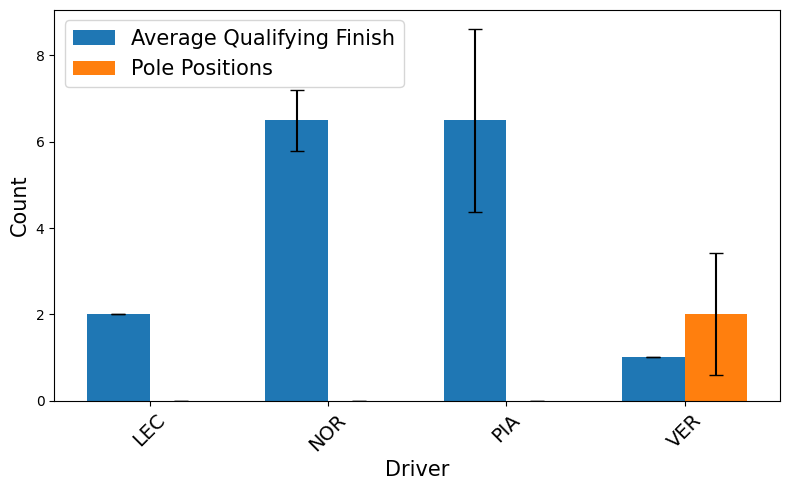

In [7]:
quali_results = quali_data[["Round", "Driver", "Position"]].drop_duplicates()
quali_results = quali_results.groupby(["Driver"]).agg({"Position": [("avg_starting_pos", "mean"), ("std_starting_pos", "std"), ("pole_count", lambda x: (x == 1).sum())]})

plt.figure(figsize=(8, 5))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], quali_results["Position"]["avg_starting_pos"], width, 
       yerr=quali_results["Position"]["std_starting_pos"], 
       capsize=5,
       label="Average Qualifying Finish")

plt.bar([i + width/2 for i in x], quali_results["Position"]["pole_count"], width,
       yerr=np.sqrt(quali_results["Position"]["pole_count"]),
       capsize=5,
       label="Pole Positions")

plt.xlabel("Driver", fontsize=15)
plt.ylabel("Count", fontsize=15)
# plt.title("2024 Qualifying Performance Comparison", fontsize=15)
plt.xticks(x, quali_results.index, rotation=45, fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig("imgs/2024 Qualifying Performance Comparison.png")
plt.show()

In [8]:
quali_results

Position                            
       avg_starting_pos std_starting_pos pole_count
Driver                                             
LEC                 2.0         0.000000          0
NOR                 6.5         0.707107          0
PIA                 6.5         2.121320          0
VER                 1.0         0.000000          2

### Telemetry Analysis

In [9]:
analyzer = F1TelemetryAnalyzer(n_samples=300)

results = analyzer.analyze_laps(
   quali_telemetry,
   rounds=range(1, 22),
   drivers=["VER", "NOR", "LEC", "PIA"],
   session_type="Qualifying",
)

processed_laps = results["processed_data"]
lap_metrics = results["lap_metrics"]
distance_matrices = results["distance_matrices"]

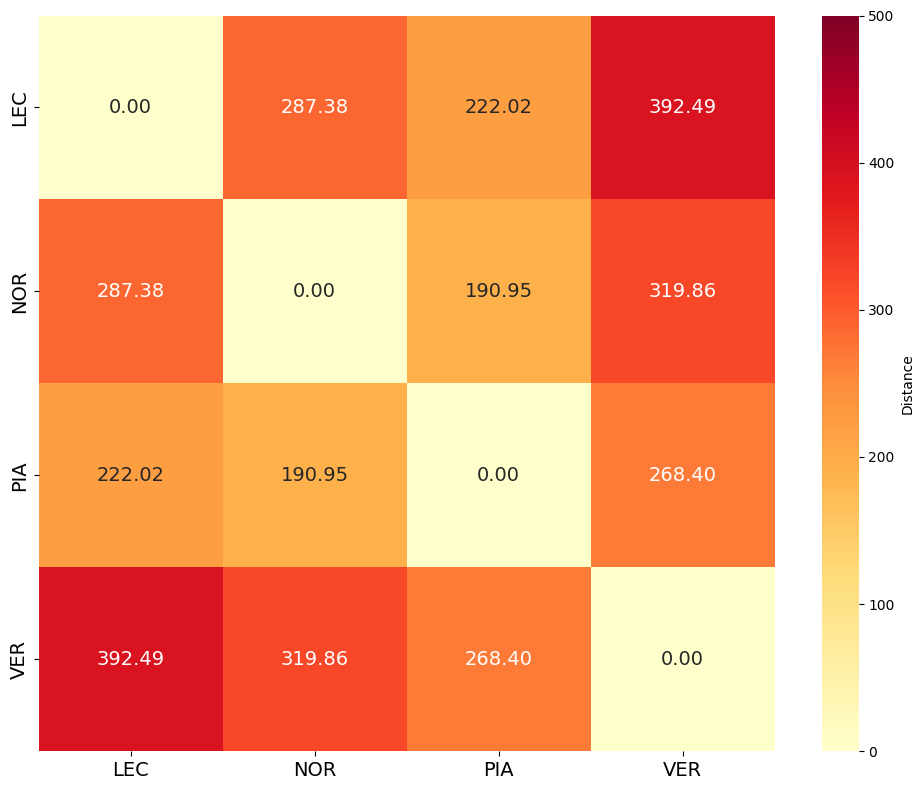

In [10]:
avg_matrix = np.mean(list(distance_matrices.values()), axis=0)

drivers = ["LEC", "NOR", "PIA", "VER"]
df = pd.DataFrame(avg_matrix, index=drivers, columns=drivers)

plt.figure(figsize=(10, 8))
sns.heatmap(df, 
            annot=True, 
            fmt=".2f",
            cmap="YlOrRd",
            square=True,
            annot_kws={'size': 14},
            cbar_kws={"label": "Distance"},
            vmin=0,
            vmax=500)

# plt.title("Average Qualifying Speed Distance Matrix")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig("imgs/Average Qualifying Speed Distance Matrix.png")
plt.show()

### Last 5 Quali Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won

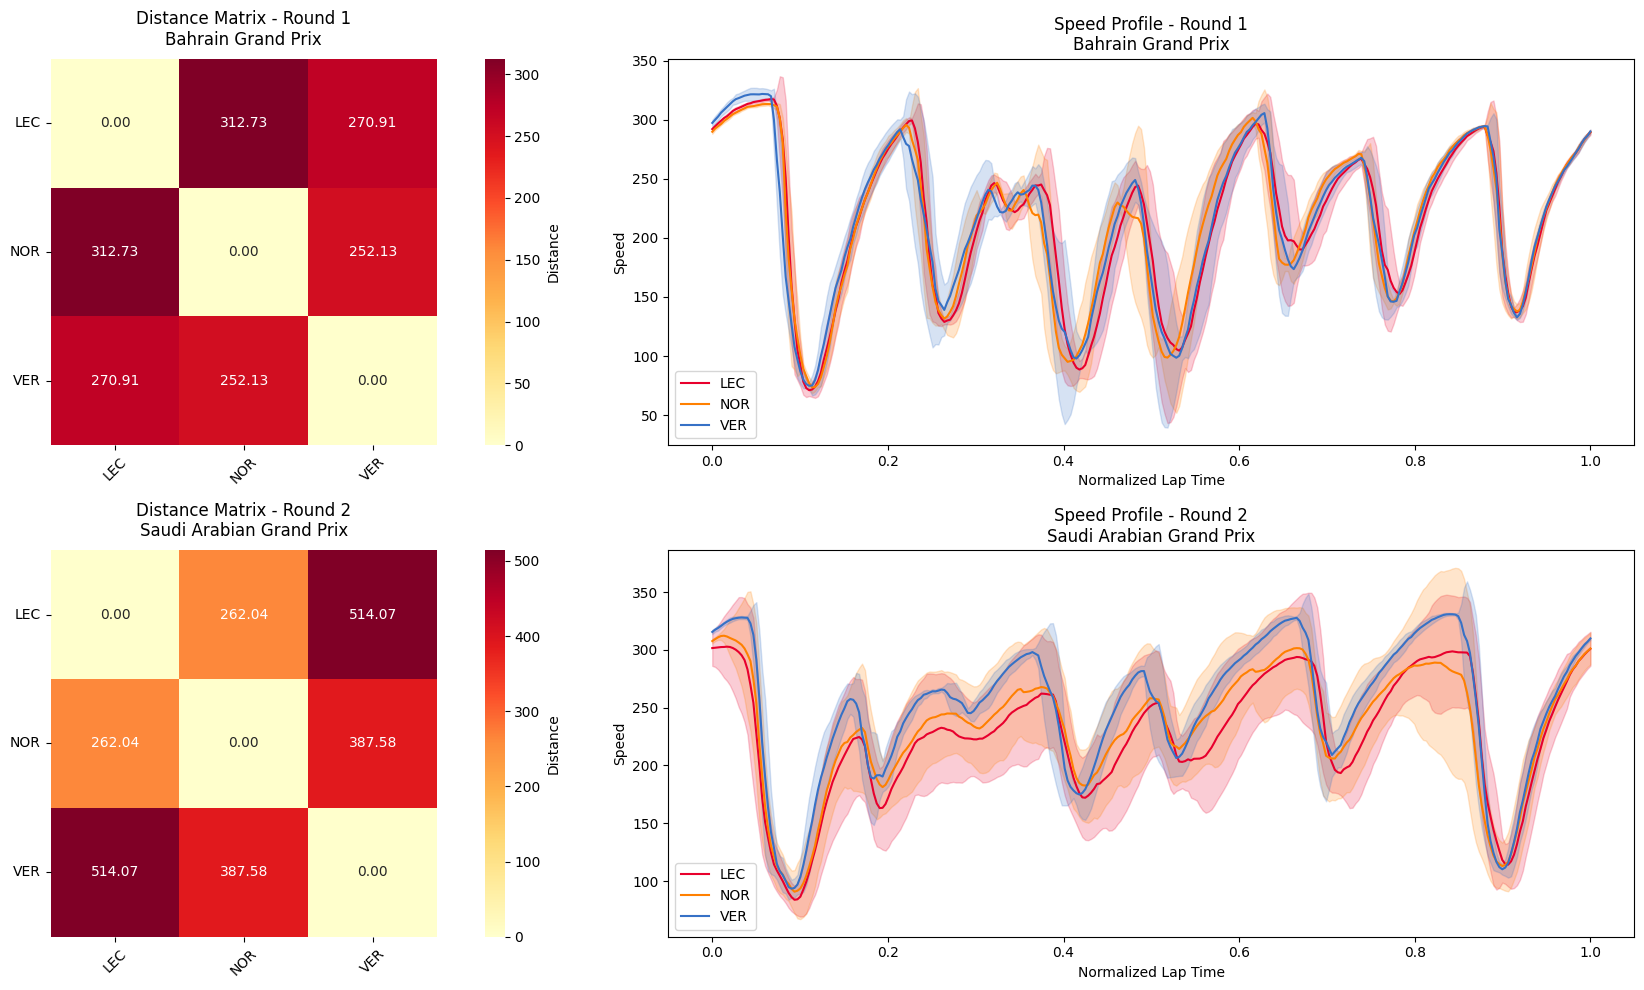

In [11]:
plot_combined_analysis(
    distance_matrices=distance_matrices,
    processed_laps=processed_laps,
    # rounds=range(17, 22),
    rounds=range(0, 5),
)

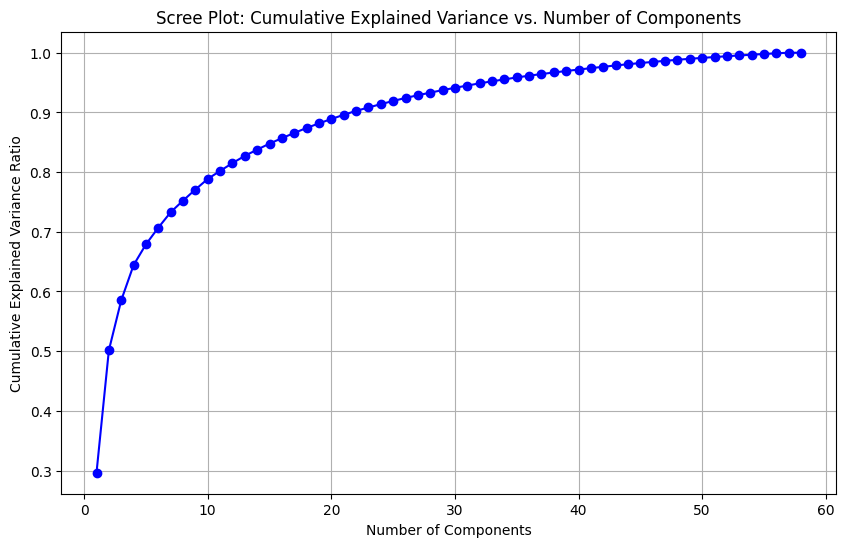

Number of components needed for 95.0% variance: 33


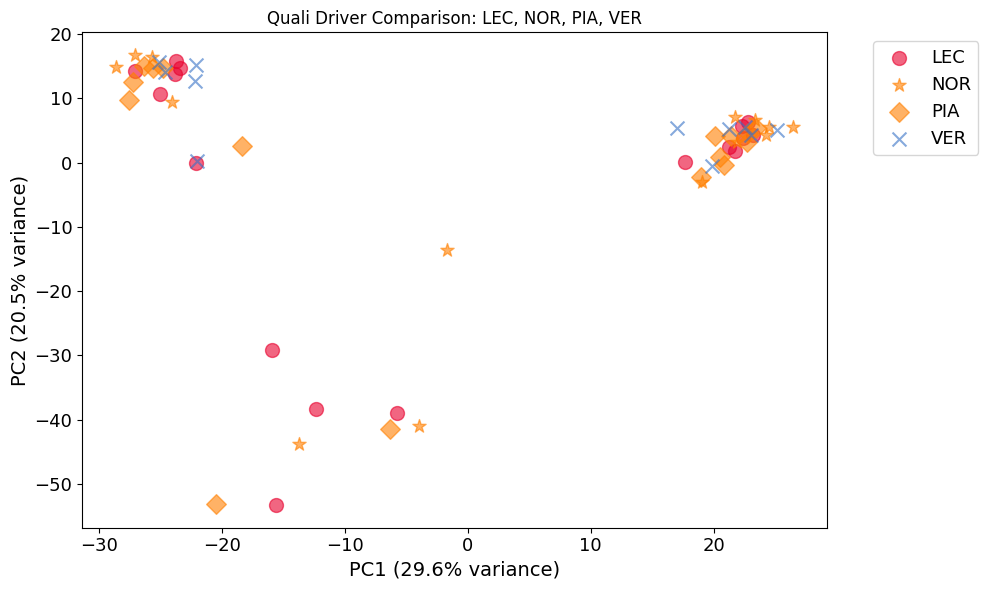

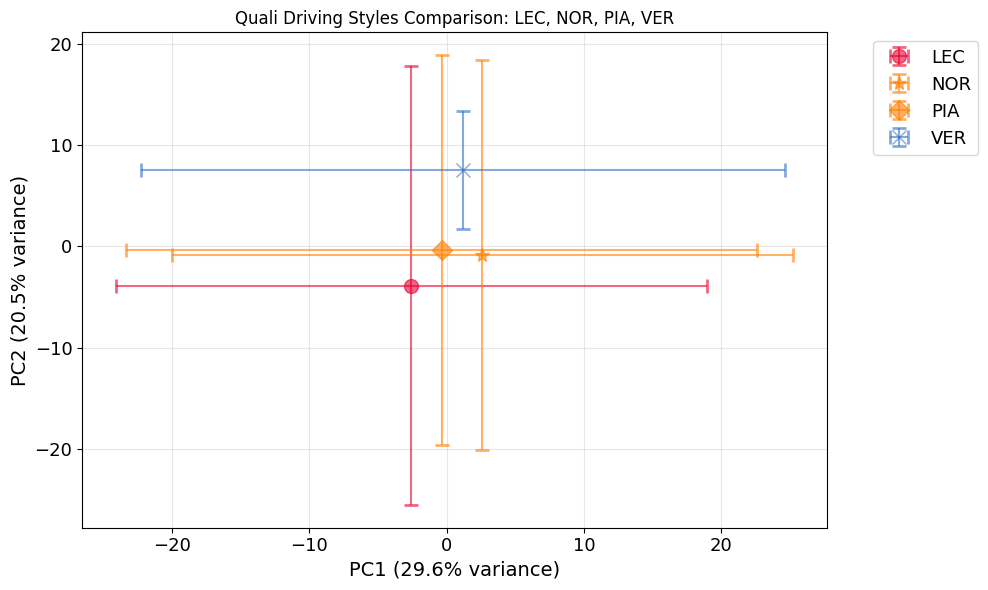


Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC    -2.558652 -3.894507 -3.207434  1.500645  1.270240  0.366749  0.953895   
NOR     2.609567 -0.817841  4.520930  0.836826 -0.761462 -0.159166 -1.288163   
PIA    -0.368497 -0.340196 -0.579656 -0.891674 -1.118443 -1.071147  0.630552   
VER     1.169009  7.554503  0.046168 -2.087250  0.632861  1.193813 -0.751889   

             PC8       PC9      PC10  ...      PC24      PC25      PC26  \
Driver                                ...                                 
LEC    -2.684239  0.000163 -0.380522  ... -0.432265 -0.246146 -0.131117   
NOR     4.642077 -2.337203  1.181535  ...  0.412557  0.566649 -0.076983   
PIA     1.988313  0.544528  1.242853  ... -0.563665 -0.629379  0.133277   
VER    -4.651819  2.182329 -2.723478  ...  0.962850  0.574677  0.106757   

            PC27 

In [12]:
results = analyzer.analyze_laps(
    telemetry_data=quali_telemetry,
    rounds=range(1, 22),
    drivers=["LEC", "NOR", "PIA", "VER",],
    pca=True,
    session_type="Quali"
)

Version 1: Adding Feature to observe loadings for each Principal Component

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: preprocess and reshape using the same analyzer ---
processed_data, lap_metrics = analyzer.preprocess_lap_data(
    telemetry_data=quali_telemetry,
    rounds=range(1, 3),
    drivers=["LEC", "NOR", "PIA", "VER"]
)

print(processed_data.head())

            RPM       Speed     nGear   DRS  Throttle  Brake  \
0  11662.000000  290.000000  7.000000  12.0      99.0    0.0   
1  11688.187291  294.000000  7.000000  12.0      99.0    0.0   
2  11812.056856  294.722408  7.000000  12.0      99.0    0.0   
3  11203.882943  297.625418  7.000000  12.0      99.0    0.0   
4  10739.792642  299.722408  7.722408  12.0      99.0    0.0   

   CumulativeDistance                      Time  LapNumber Driver  Round  \
0            0.000000    0 days 00:00:00.129000          1    LEC      1   
1           22.232999 0 days 00:00:00.365120401          1    LEC      1   
2           65.551171 0 days 00:00:00.586792642          1    LEC      1   
3          130.448978 0 days 00:00:00.819033445          1    LEC      1   
4          224.936306 0 days 00:00:01.131274247          1    LEC      1   

   normalized_time  
0         0.000000  
1         0.003344  
2         0.006689  
3         0.010033  
4         0.013378  


In [14]:
print(lap_metrics.head())

   round driver  lap  duration   max_speed   avg_speed  brake_applications  \
0      1    LEC    1    91.120  315.000000  213.644994                  63   
1      1    LEC    2    90.080  317.989967  213.206198                  59   
2      1    LEC    3    89.841  317.000000  216.113779                  54   
3      1    LEC    4    88.961  319.000000  215.894036                  59   
4      1    LEC    5    89.201  319.000000  215.486276                  65   

   drs_zones  
0        300  
1        300  
2        300  
3        300  
4        300  


In [23]:
# Reshaped to each lap
reshaped_data = analyzer._reshape_telemetry_data(processed_data)
# print(reshaped_data.head())

In [24]:
# --- STEP 2: scale data ---
X = reshaped_data.loc[(slice(None), ["LEC", "NOR", "PIA", "VER"]), :]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- STEP 3: run PCA manually (choose number of components) ---
n_components = 33  # adjust as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
# print(X_pca)



Top 10 features influencing PC1 and PC2:
                   PC1       PC2  Magnitude
Throttle_10   0.010036  0.051329   0.052300
Throttle_11   0.009787  0.051258   0.052184
Throttle_169  0.011491  0.050669   0.051955
Throttle_135  0.010442  0.050683   0.051748
Throttle_170  0.011050  0.050535   0.051729
Throttle_168  0.011873  0.050270   0.051653
Speed_220     0.000487  0.051431   0.051433
Throttle_9    0.010254  0.050337   0.051371
Throttle_134  0.011388  0.050029   0.051308
Throttle_167  0.011679  0.049954   0.051301


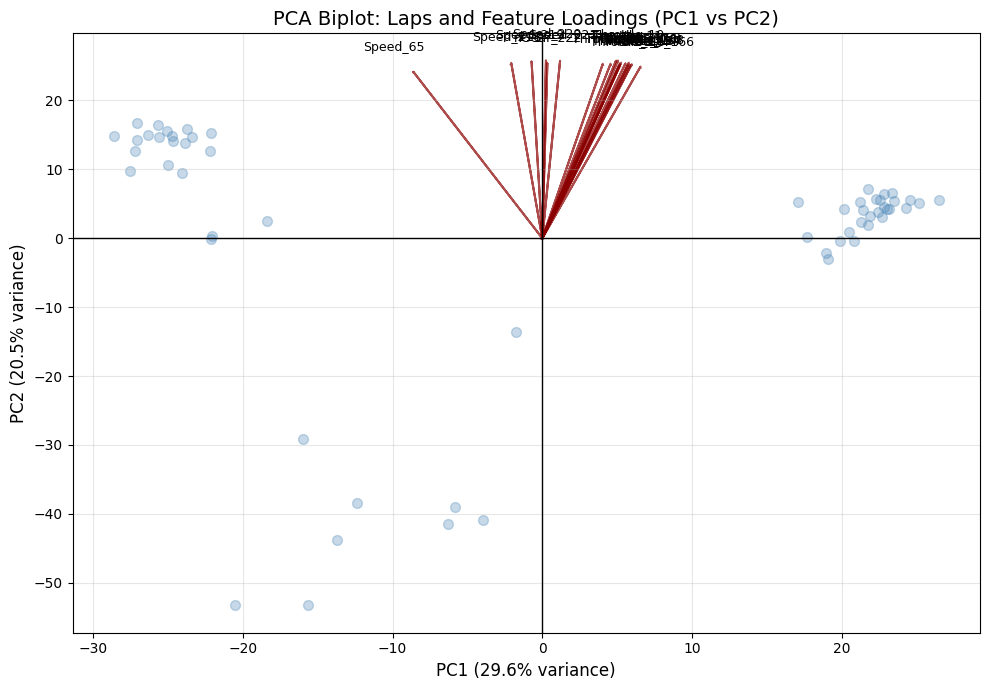

In [35]:

# --- Extract loadings (feature contributions) ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

# --- Compute combined magnitude for ranking ---
loadings["Magnitude"] = np.sqrt(loadings["PC1"]**2 + loadings["PC2"]**2)
loadings_sorted = loadings.sort_values("Magnitude", ascending=False)

# --- Display top 10 features contributing to PC1 & PC2 ---
print("\nTop 10 features influencing PC1 and PC2:")
print(loadings_sorted[["PC1", "PC2", "Magnitude"]].head(10))

# --- Scale loadings for visibility in plot ---
scaling_factor = 500  # adjust arrow length (try 3–10)
loadings_scaled = loadings[["PC1", "PC2"]] * scaling_factor

# --- Create simple PCA DataFrame (optional for scatter plot) ---
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
pca_df["PC1"] = X_pca[:, 0]
pca_df["PC2"] = X_pca[:, 1]

# --- Plot setup ---
plt.figure(figsize=(10, 7))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.3, color="steelblue", s=50)

# --- Overlay loadings as arrows ---
for feature in loadings_sorted.index[:20]:  # show top 10 for clarity
    x = loadings_scaled.loc[feature, "PC1"]
    y = loadings_scaled.loc[feature, "PC2"]
    plt.arrow(0, 0, x, y, color="darkred", alpha=0.7, head_width=0.05, linewidth=1.5)
    plt.text(x * 1.15, y * 1.15, feature, fontsize=9, color="black", ha='center', va='center')

# --- Labels & styling ---
plt.axhline(0, color="black", lw=1)
plt.axvline(0, color="black", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=12)
plt.title("PCA Biplot: Laps and Feature Loadings (PC1 vs PC2)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Version 2: PCA of  lap metrics


Top 10 features influencing PC1 and PC2:
                         PC1       PC2  Magnitude
brake_applications -0.424324  0.370504   0.563315
max_speed           0.500446  0.252581   0.560575
duration           -0.323885 -0.454201   0.557853
round               0.344208 -0.429867   0.550695
avg_speed           0.526375  0.144305   0.545797
driver_VER          0.077599  0.463397   0.469849
lap                 0.248792 -0.307288   0.395378
driver_NOR          0.022813 -0.264149   0.265133
driver_PIA         -0.024743 -0.089911   0.093254
drs_zones           0.000000 -0.000000   0.000000


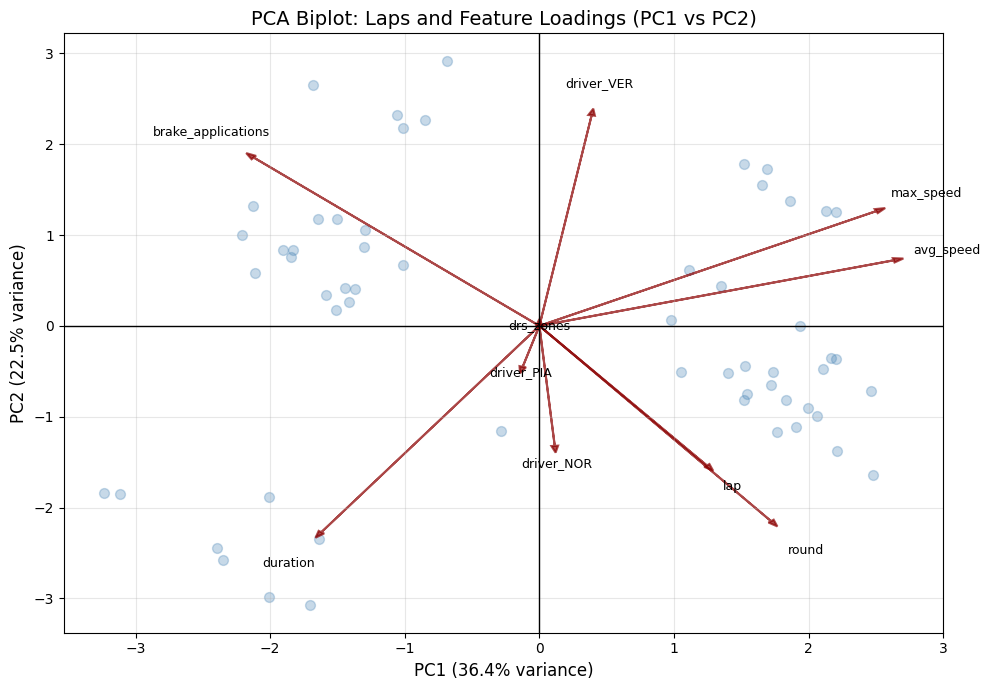

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- STEP 2: scale data ---
X = pd.get_dummies(
    lap_metrics,
    columns=['driver'],
    drop_first=True
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- STEP 3: run PCA manually (choose number of components) ---
n_components = 5  # adjust as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# --- Extract loadings (feature contributions) ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

# --- Compute combined magnitude for ranking ---
loadings["Magnitude"] = np.sqrt(loadings["PC1"]**2 + loadings["PC2"]**2)
loadings_sorted = loadings.sort_values("Magnitude", ascending=False)

# --- Display top 10 features contributing to PC1 & PC2 ---
print("\nTop 10 features influencing PC1 and PC2:")
print(loadings_sorted[["PC1", "PC2", "Magnitude"]].head(10))

# --- Scale loadings for visibility in plot ---
scaling_factor = 5  # adjust arrow length (try 3–10)
loadings_scaled = loadings[["PC1", "PC2"]] * scaling_factor

# --- Create simple PCA DataFrame (optional for scatter plot) ---
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
pca_df["PC1"] = X_pca[:, 0]
pca_df["PC2"] = X_pca[:, 1]

# --- Plot setup ---
plt.figure(figsize=(10, 7))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.3, color="steelblue", s=50)

# --- Overlay loadings as arrows ---
for feature in loadings_sorted.index[:10]:  # show top 10 for clarity
    x = loadings_scaled.loc[feature, "PC1"]
    y = loadings_scaled.loc[feature, "PC2"]
    plt.arrow(0, 0, x, y, color="darkred", alpha=0.7, head_width=0.05, linewidth=1.5)
    plt.text(x * 1.15, y * 1.15, feature, fontsize=9, color="black", ha='center', va='center')

# --- Labels & styling ---
plt.axhline(0, color="black", lw=1)
plt.axvline(0, color="black", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=12)
plt.title("PCA Biplot: Laps and Feature Loadings (PC1 vs PC2)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Version 3: PCA of processed data

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

processed_data_pca = processed_data.drop(columns=['Time', 'CumulativeDistance', 'normalized_time'])

In [20]:
# --- STEP 2: scale data ---
# X = reshaped_data.loc[(slice(None), ["LEC", "NOR", "PIA", "VER"]), :]
X = pd.get_dummies(
    processed_data_pca,
    columns=['Driver'],
    # drop_first=True
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Top 10 features influencing PC1 and PC2:
                 PC1       PC2  Magnitude
LapNumber   0.070297  0.576363   0.580634
Driver_VER  0.018321 -0.538920   0.539232
Speed       0.500871 -0.015325   0.501105
Round       0.086419  0.468264   0.476171
nGear       0.442181 -0.004597   0.442205
Throttle    0.430580 -0.058367   0.434518
RPM         0.425555  0.001191   0.425557
Driver_LEC -0.030387  0.370215   0.371460
DRS         0.327247 -0.083279   0.337677
Brake      -0.256980  0.000259   0.256980


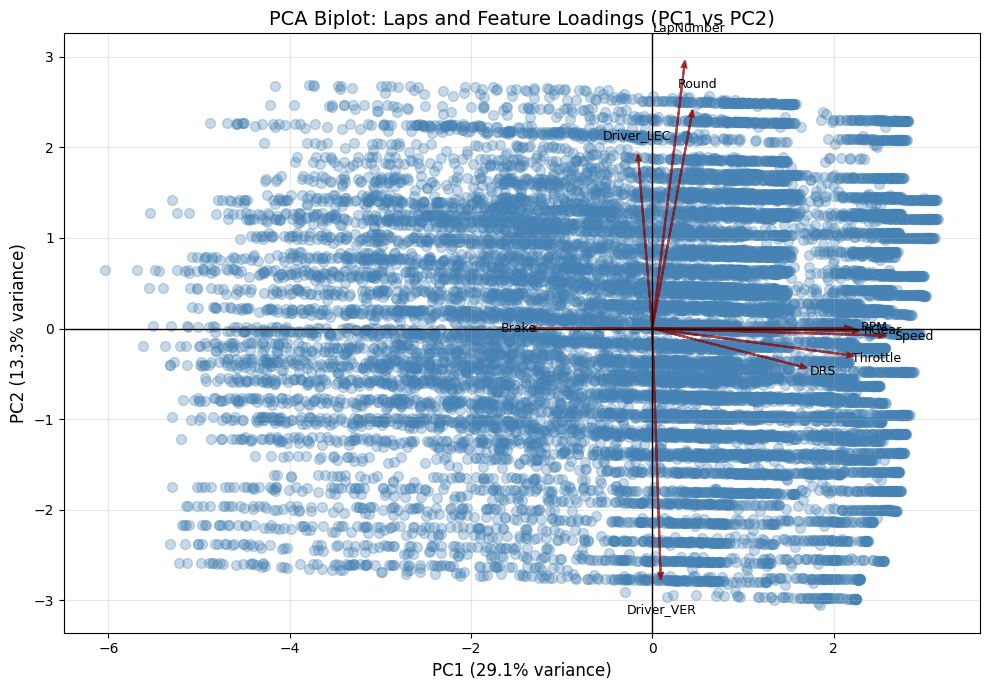

In [21]:

# --- STEP 3: run PCA manually (choose number of components) ---
n_components = 5  # adjust as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# --- Extract loadings (feature contributions) ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

# --- Compute combined magnitude for ranking ---
loadings["Magnitude"] = np.sqrt(loadings["PC1"]**2 + loadings["PC2"]**2)
loadings_sorted = loadings.sort_values("Magnitude", ascending=False)

# --- Display top 10 features contributing to PC1 & PC2 ---
print("\nTop 10 features influencing PC1 and PC2:")
print(loadings_sorted[["PC1", "PC2", "Magnitude"]].head(10))

# --- Scale loadings for visibility in plot ---
scaling_factor = 5  # adjust arrow length (try 3–10)
loadings_scaled = loadings[["PC1", "PC2"]] * scaling_factor

# --- Create simple PCA DataFrame (optional for scatter plot) ---
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
pca_df["PC1"] = X_pca[:, 0]
pca_df["PC2"] = X_pca[:, 1]

# --- Plot setup ---
plt.figure(figsize=(10, 7))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.3, color="steelblue", s=50)

# --- Overlay loadings as arrows ---
for feature in loadings_sorted.index[:10]:  # show top 10 for clarity
    x = loadings_scaled.loc[feature, "PC1"]
    y = loadings_scaled.loc[feature, "PC2"]
    plt.arrow(0, 0, x, y, color="darkred", alpha=0.7, head_width=0.05, linewidth=1.5)
    plt.text(x * 1.15, y * 1.15, feature, fontsize=9, color="black", ha='center', va='center')

# --- Labels & styling ---
plt.axhline(0, color="black", lw=1)
plt.axvline(0, color="black", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=12)
plt.title("PCA Biplot: Laps and Feature Loadings (PC1 vs PC2)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Race Performance
Similar to qualifying sessions, we use two datasets here `race_data` and `race_telemetry`.

In [22]:
# Define custom cache directory
cache_dir = r"C:\Enzo_Files\AIM Data Science"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

# Initialize processor with the same path
processor = F1DataProcessor(cache_dir=cache_dir, year=2024)

# Get normalized qualifying data

race_data, race_telemetry = processor.get_race_session(
    # rounds=range(1, 22),
    rounds=range(1, 3), # 22 races total
    drivers=["VER", "NOR", "LEC", "PIA"],
    normalize_telemetry=True, 
    target_points=300
)

In [23]:
# processor = F1DataProcessor(cache_dir="cache", year=2024)

# race_data, race_telemetry = processor.get_race_session(
#     rounds=range(1, 4),
#     drivers=["VER", "NOR", "LEC", "PIA"],
#     normalize_telemetry=True, 
#     target_points=300
# )

In [24]:
race_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,Position
0,1,VER,1,Red Bull Racing,0 days 00:01:37.284000,1.0,1.0,NaN,41.266,23.616,...,False,SOFT,4.0,False,12,False,,2024-03-02 15:03:42.342,2024-03-02 15:05:19.626,1.0
1,1,VER,1,Red Bull Racing,0 days 00:01:36.296000,2.0,1.0,30.916,41.661,23.719,...,True,SOFT,5.0,False,1,False,,2024-03-02 15:05:19.920,2024-03-02 15:06:56.216,1.0
2,1,VER,1,Red Bull Racing,0 days 00:01:36.753000,3.0,1.0,30.999,41.966,23.788,...,False,SOFT,6.0,False,1,False,,2024-03-02 15:06:56.216,2024-03-02 15:08:32.969,1.0
3,1,VER,1,Red Bull Racing,0 days 00:01:36.647000,4.0,1.0,30.931,41.892,23.824,...,False,SOFT,7.0,False,1,False,,2024-03-02 15:08:32.969,2024-03-02 15:10:09.616,1.0
4,1,VER,1,Red Bull Racing,0 days 00:01:37.173000,5.0,1.0,31.255,42.056,23.862,...,False,SOFT,8.0,False,1,False,,2024-03-02 15:10:09.616,2024-03-02 15:11:46.789,1.0


In [25]:
print(race_telemetry.head())

           RPM      Speed  nGear  DRS   Throttle     Brake  \
0  9963.000000   0.000000    1.0  1.0  15.000000  1.000000   
1  9464.230769   0.692308    1.0  1.0  15.000000  0.769231   
2  7719.615385   6.692308    1.0  1.0  15.000000  0.000000   
3  6039.615385  15.153846    1.0  1.0  15.000000  0.000000   
4  3884.846154  29.000000    1.0  1.0  19.615385  0.000000   

   CumulativeDistance                      Time  LapNumber Driver  Round  
0            0.000000    0 days 00:00:00.048000          1    VER      1  
1            0.046154 0 days 00:00:00.343384615          1    VER      1  
2            0.630769 0 days 00:00:00.638769231          1    VER      1  
3            2.302564 0 days 00:00:00.878769231          1    VER      1  
4            7.450427 0 days 00:00:01.296307692          1    VER      1  


In [26]:
race_data[["Round", "Driver", "Position"]].drop_duplicates()


,Round,Driver,Position
0,1,VER,1.0
171,1,LEC,4.0
285,1,NOR,6.0
399,1,PIA,8.0
0,2,VER,1.0
151,2,LEC,3.0
652,2,NOR,8.0
851,2,PIA,4.0


In [26]:
race_results = race_data[["Round", "Driver", "Position"]].drop_duplicates()
race_results = race_results.groupby(["Driver"]).agg({"Position": [("avg_finish_pos", "mean"), ("std_finish_pos", "std")]})
race_results.columns = race_results.columns.get_level_values(1)
race_results

,avg_finish_pos,std_finish_pos
Driver,,
LEC,3.5,0.707107
NOR,7.0,1.414214
PIA,6.0,2.828427
VER,1.0,0.000000


In [28]:
quali_results.columns = quali_results.columns.get_level_values(1)
quali_results

,avg_starting_pos,std_starting_pos,pole_count
Driver,,,
LEC,2.0,0.000000,0
NOR,6.5,0.707107,0
PIA,6.5,2.121320,0
VER,1.0,0.000000,2


In [29]:
gp_result = race_results.join(quali_results)
gp_result

,avg_finish_pos,std_finish_pos,avg_starting_pos,std_starting_pos,pole_count
Driver,,,,,
LEC,3.5,0.707107,2.0,0.000000,0
NOR,7.0,1.414214,6.5,0.707107,0
PIA,6.0,2.828427,6.5,2.121320,0
VER,1.0,0.000000,1.0,0.000000,2


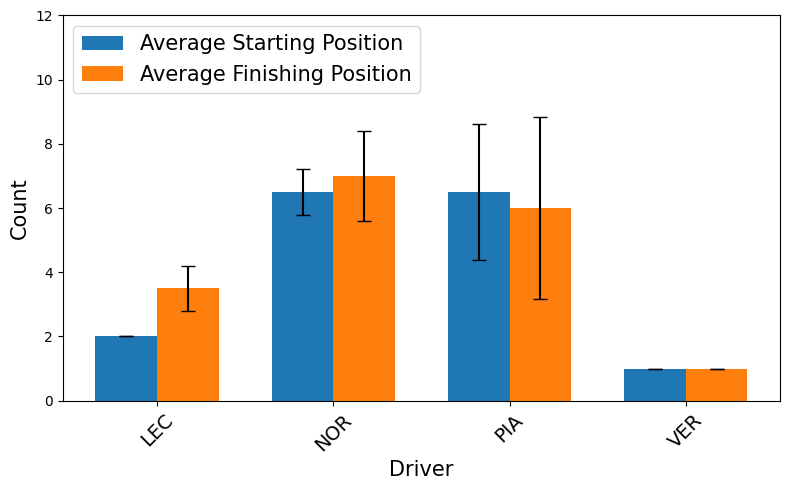

In [30]:
plt.figure(figsize=(8, 5))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], gp_result["avg_starting_pos"], width, 
       yerr=gp_result["std_starting_pos"], 
       capsize=5,
       label="Average Starting Position")

plt.bar([i + width/2 for i in x], gp_result["avg_finish_pos"], width,
       yerr=gp_result["std_finish_pos"],
       capsize=5,
       label="Average Finishing Position")

plt.xlabel("Driver", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.ylim(0, 12)
# plt.title("2024 Qualifying Performance Comparison", fontsize=15)
plt.xticks(x, quali_results.index, rotation=45, fontsize=14)
plt.legend(loc="upper left", fontsize=15)
plt.tight_layout()
# plt.savefig("imgs/2024 Qualifying vs Race Performance.png")
plt.show()

In [31]:
pole_count = quali_data[["Driver", "Round", "Position"]].drop_duplicates().rename(columns={"Position":"QualiResult"})
pole_count

,Driver,Round,QualiResult
18,LEC,1,2.0
118,PIA,1,8.0
103,NOR,1,7.0
1,VER,1,1.0
78,PIA,2,5.0
100,NOR,2,6.0
19,LEC,2,2.0
1,VER,2,1.0


In [32]:
finish_count = race_data[["Driver", "Round", "Position"]].drop_duplicates().rename(columns={"Position":"RaceResult"})
finish_count

,Driver,Round,RaceResult
0,VER,1,1.0
171,LEC,1,4.0
285,NOR,1,6.0
399,PIA,1,8.0
0,VER,2,1.0
151,LEC,2,3.0
652,NOR,2,8.0
851,PIA,2,4.0


In [33]:
merged_df = pd.merge(finish_count, pole_count, on=["Driver", "Round"])

poles = merged_df[merged_df["QualiResult"] == 1].groupby("Driver").size()
wins = merged_df[merged_df["RaceResult"] == 1].groupby("Driver").size()
poles_and_wins = merged_df[(merged_df["QualiResult"] == 1) & (merged_df["RaceResult"] == 1)].groupby("Driver").size()

# Create a dataframe with all metrics
conversion_stats = pd.DataFrame({
   "pole_count": poles,
   "win_count": wins,
   "poles_converted": poles_and_wins,
   "conversion_rate": (poles_and_wins / poles * 100).round(2)
})

conversion_stats.dropna()

,pole_count,win_count,poles_converted,conversion_rate
Driver,,,,
VER,2,2,2,100.0


### Telemetry Analysis

In [34]:
print(race_telemetry.head())

           RPM      Speed  nGear  DRS   Throttle     Brake  \
0  9963.000000   0.000000    1.0  1.0  15.000000  1.000000   
1  9464.230769   0.692308    1.0  1.0  15.000000  0.769231   
2  7719.615385   6.692308    1.0  1.0  15.000000  0.000000   
3  6039.615385  15.153846    1.0  1.0  15.000000  0.000000   
4  3884.846154  29.000000    1.0  1.0  19.615385  0.000000   

   CumulativeDistance                      Time  LapNumber Driver  Round  
0            0.000000    0 days 00:00:00.048000          1    VER      1  
1            0.046154 0 days 00:00:00.343384615          1    VER      1  
2            0.630769 0 days 00:00:00.638769231          1    VER      1  
3            2.302564 0 days 00:00:00.878769231          1    VER      1  
4            7.450427 0 days 00:00:01.296307692          1    VER      1  


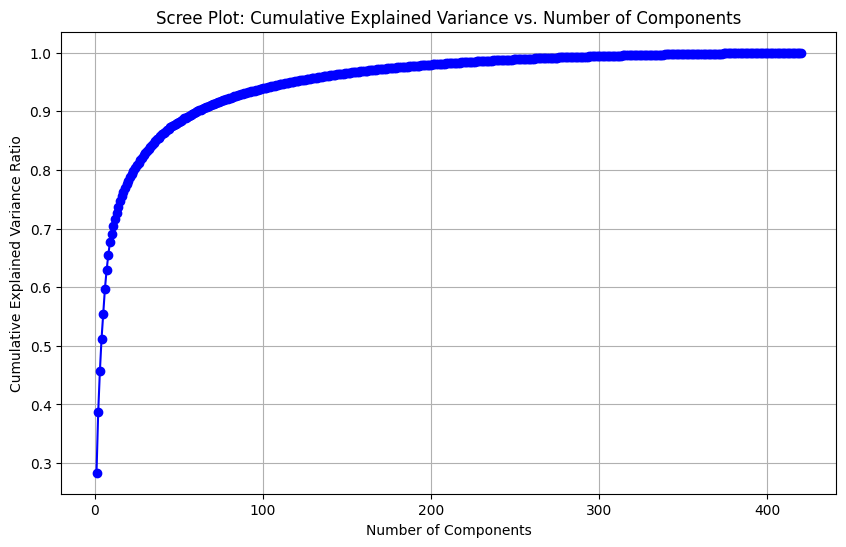

Number of components needed for 95.0% variance: 117


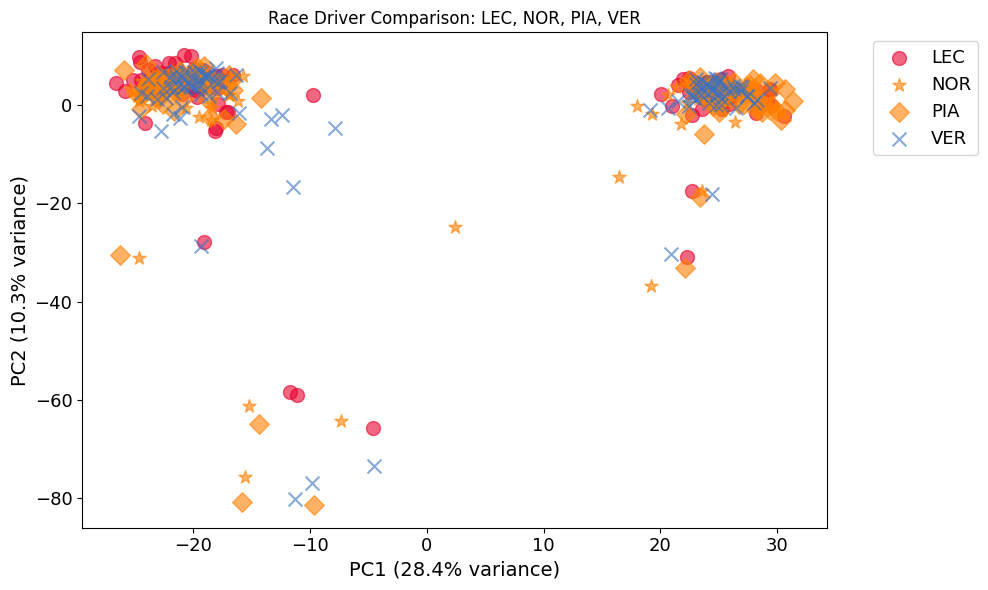

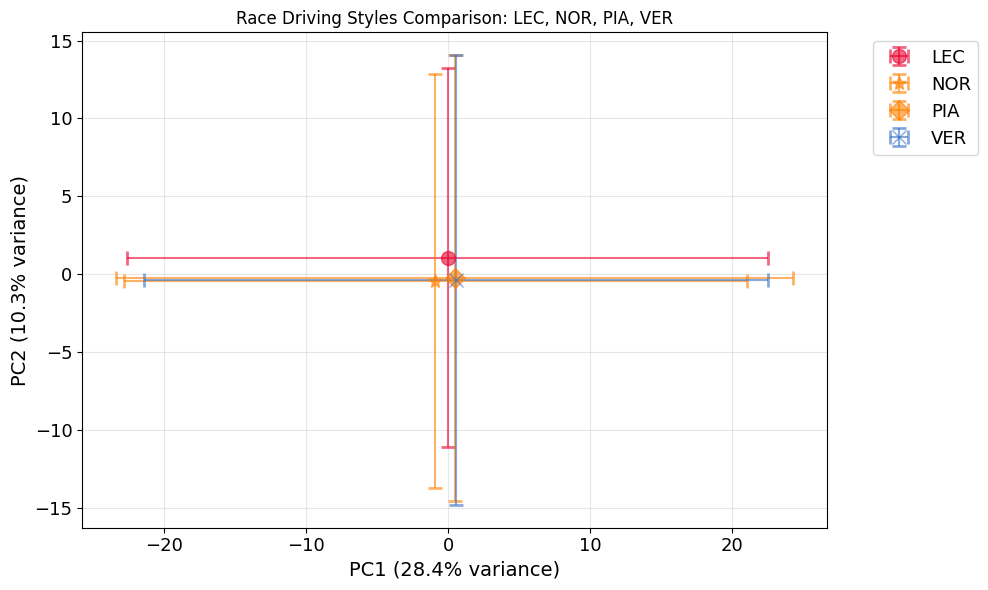


Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC    -0.043567  1.070471  0.313115  0.380357  2.351399  0.793558 -1.713011   
NOR    -0.933818 -0.427539  0.693732 -0.534663 -2.664385  1.005375  0.600066   
PIA     0.445666 -0.268855 -2.127465  0.607699  3.568587 -1.292988  0.413323   
VER     0.531720 -0.374077  1.120619 -0.453393 -3.255600 -0.505944  0.699623   

             PC8       PC9      PC10  ...     PC108     PC109     PC110  \
Driver                                ...                                 
LEC    -1.794941  1.351205 -0.897606  ... -0.049156  0.140826  0.037684   
NOR    -0.474858 -0.269261  1.753608  ...  0.064201 -0.090259 -0.036278   
PIA     2.509178 -1.089037  1.268156  ... -0.103684  0.020056  0.055756   
VER    -0.239379  0.007093 -2.124157  ...  0.088638 -0.070623 -0.057163   

           PC111 

In [35]:
analyzer = F1TelemetryAnalyzer(n_samples=300)

results = analyzer.analyze_laps(
   race_telemetry,
   rounds=range(1, 22),
   drivers=["LEC", "NOR", "PIA", "VER",],
   session_type="Race",
   pca=True,
)

processed_laps = results["processed_data"]
lap_metrics = results["lap_metrics"]
distance_matrices = results["distance_matrices"]

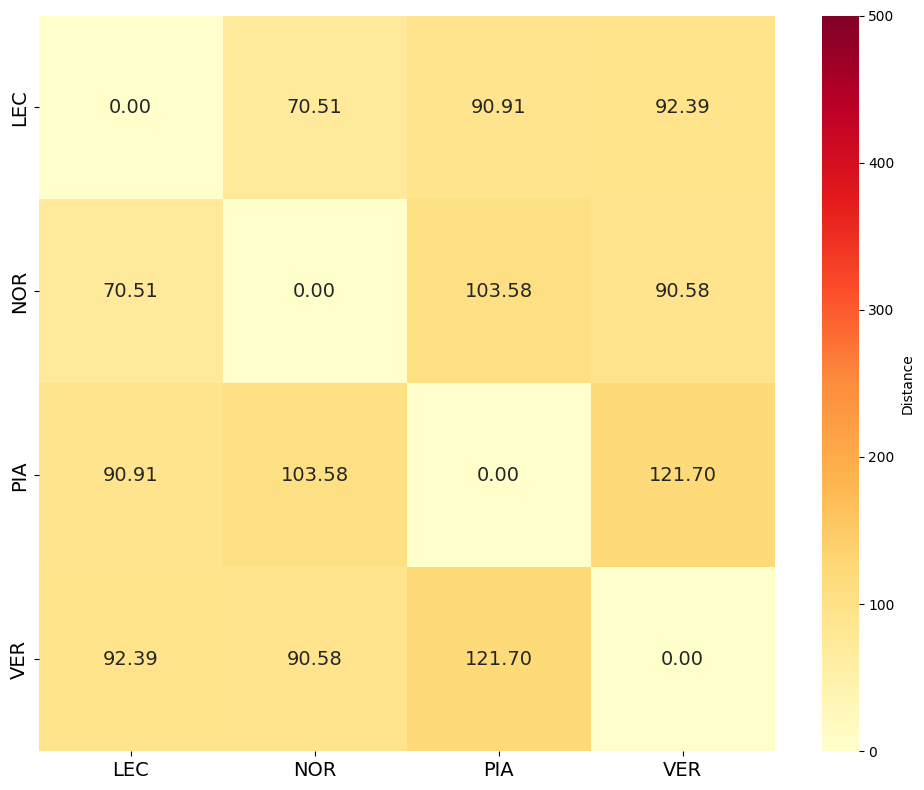

In [36]:
avg_matrix = np.mean(list(distance_matrices.values()), axis=0)

drivers = ["LEC", "NOR", "PIA", "VER"]
df = pd.DataFrame(avg_matrix, index=drivers, columns=drivers)

plt.figure(figsize=(10, 8))
sns.heatmap(df, 
            annot=True, 
            fmt=".2f",
            cmap="YlOrRd",
            square=True,
            annot_kws={'size': 14},
            cbar_kws={"label": "Distance"},
            vmin=0,
            vmax=500)

# plt.title("Average Qualifying Speed Distance Matrix")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig("imgs/Average Race Speed Distance Matrix.png")
plt.show()

### Last 5 Races Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won

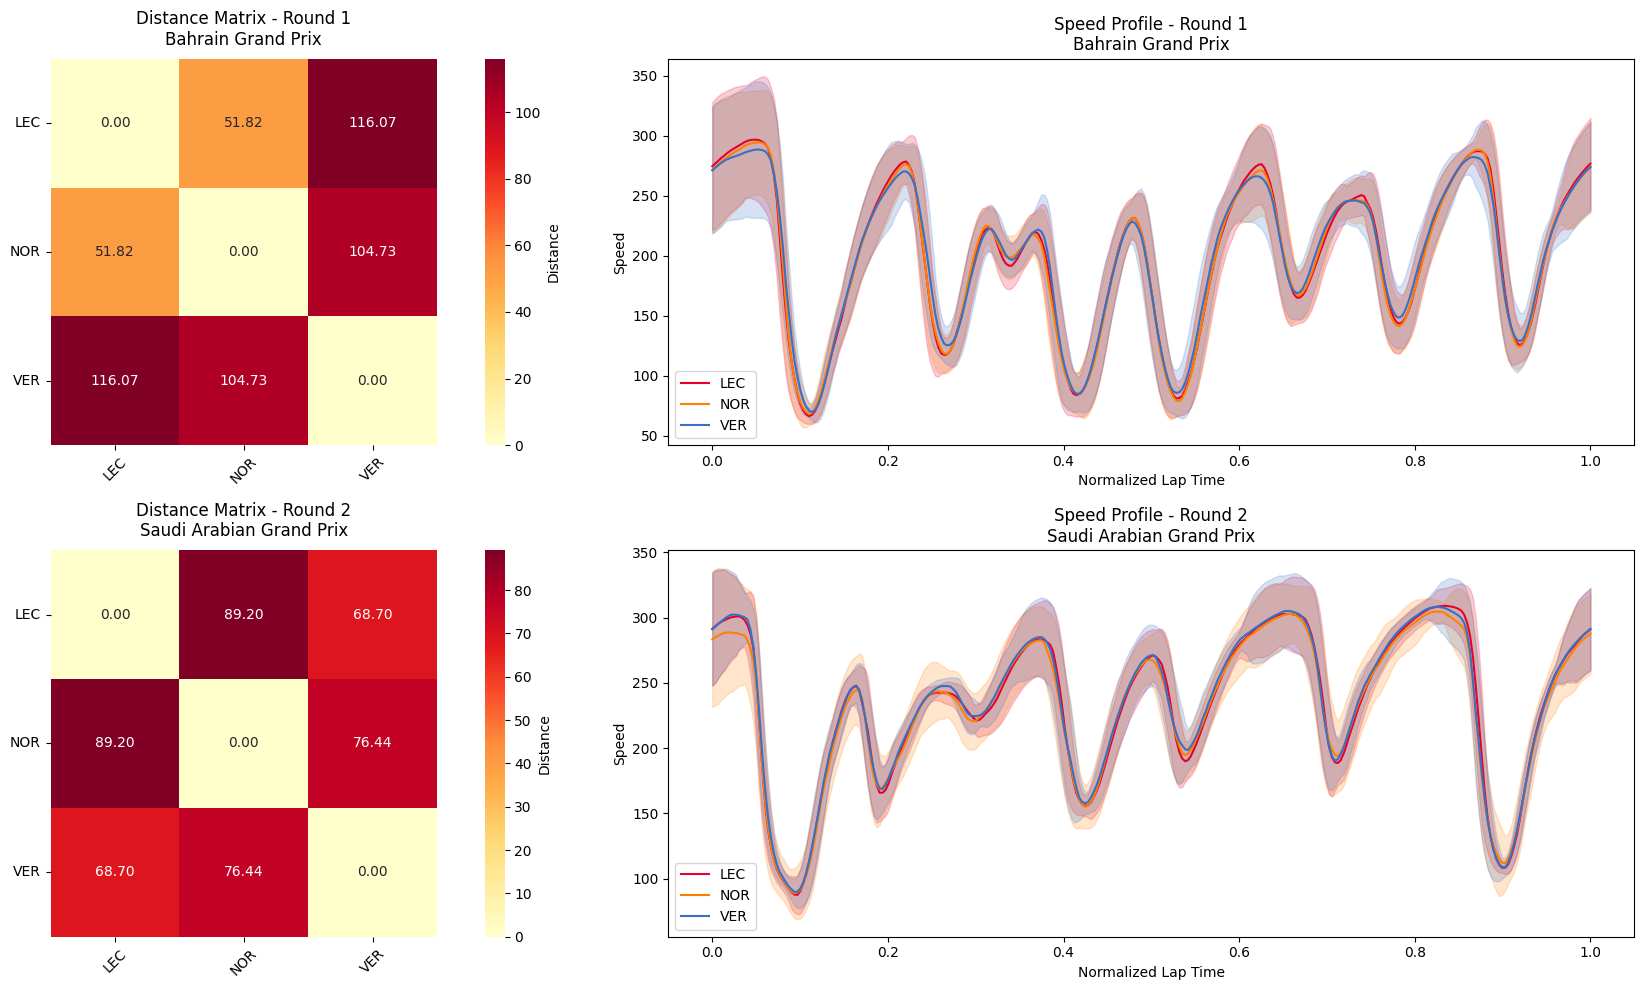

In [37]:
plot_combined_analysis(
    distance_matrices=distance_matrices,
    processed_laps=processed_laps,
    rounds=range(0, 22),
)

## Driver Performance Index

Number of components needed for 95.0% variance: 33

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC    -2.558652 -3.894507 -3.207434  1.500645  1.270241  0.366748  0.953896   
NOR     2.609567 -0.817841  4.520930  0.836826 -0.761462 -0.159166 -1.288164   
PIA    -0.368497 -0.340196 -0.579656 -0.891674 -1.118444 -1.071145  0.630553   
VER     1.169009  7.554503  0.046168 -2.087250  0.632861  1.193812 -0.751891   

             PC8       PC9      PC10  ...      PC24      PC25      PC26  \
Driver                                ...                                 
LEC    -2.684254  0.000183 -0.380508  ...  0.429383 -0.246870 -0.117756   
NOR     4.642072 -2.337211  1.181539  ... -0.426826  0.560670 -0.072521   
PIA     1.988331  0.544519  1.242844  ...  0.571209 -0.624940  0.116103   
VER    -4.651817  2.182321 -2.723492  ... 

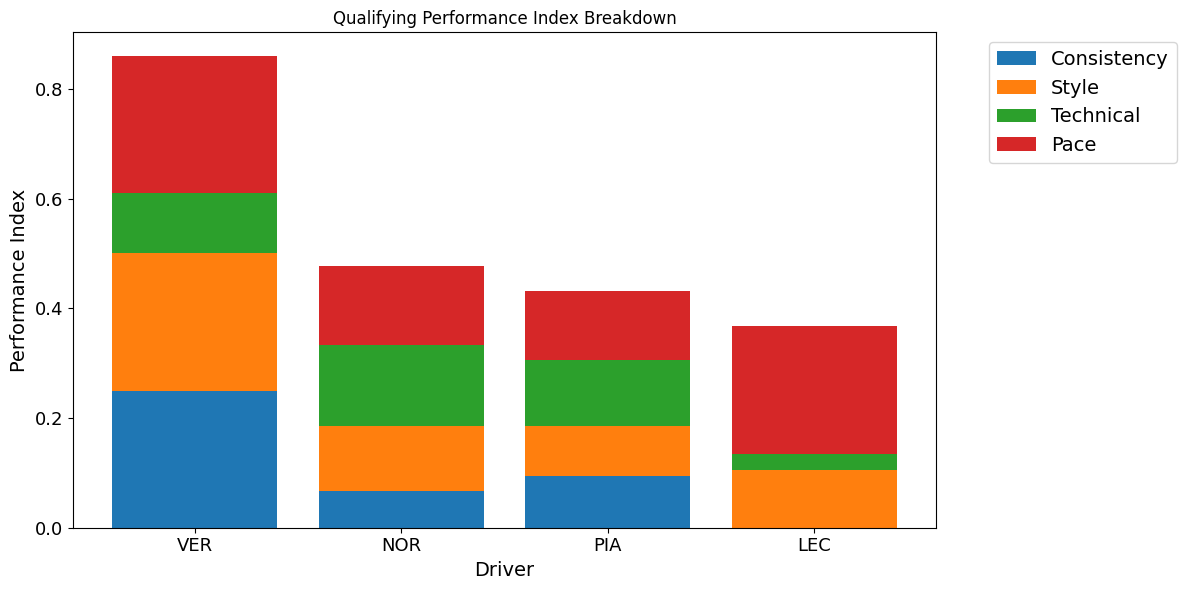

In [ ]:
# Initialize the components
# Define custom cache directory
cache_dir = r"C:\Enzo_Files\AIM Data Science"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

data_processor = F1DataProcessor(cache_dir=cache_dir, year=2024)
telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

performance_analyzer = F1DriverPerformanceIndex(
    data_processor=data_processor,
    telemetry_analyzer=telemetry_analyzer,
    session_type="Qualifying"
)

performance_index = performance_analyzer.calculate_performance_index(
    rounds=range(1, 4),
    drivers=["LEC", "NOR", "PIA", "VER"]
)

perf_idx = performance_analyzer.plot_performance_breakdown(performance_index)

In [ ]:
perf_idx

,Driver,Consistency,Style,Technical,Pace,PerformanceIndex
3,VER,0.637447,0.106317,0.438824,1.000000,0.545647
1,PIA,0.644414,0.530919,0.410579,0.500000,0.521478
0,LEC,0.415040,0.207003,0.250000,0.928571,0.450154
2,NOR,0.000000,0.500000,0.433638,0.571429,0.376267


Number of components needed for 95.0% variance: 129

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC     2.280042 -1.085992  0.821630  1.753872  0.530608  0.469921 -0.462627   
NOR     1.831889 -1.543858  0.920466 -2.948370 -0.549690 -0.092273  0.642810   
PIA     2.190449 -0.625801 -1.241024  2.398543 -0.197888  0.017093 -0.041774   
VER    -9.511925  4.913620 -0.756247 -1.817216  0.327463 -0.595766 -0.208895   

             PC8       PC9      PC10  ...     PC120     PC121     PC122  \
Driver                                ...                                 
LEC    -0.760766 -0.311700 -0.131905  ... -0.102502 -0.035463 -0.061066   
NOR    -0.267845 -0.011357 -0.388901  ...  0.018911 -0.031910 -0.024152   
PIA     1.881946  1.063481 -0.774764  ...  0.099060  0.004987  0.101769   
VER    -1.287905 -1.117492  1.955350  ...

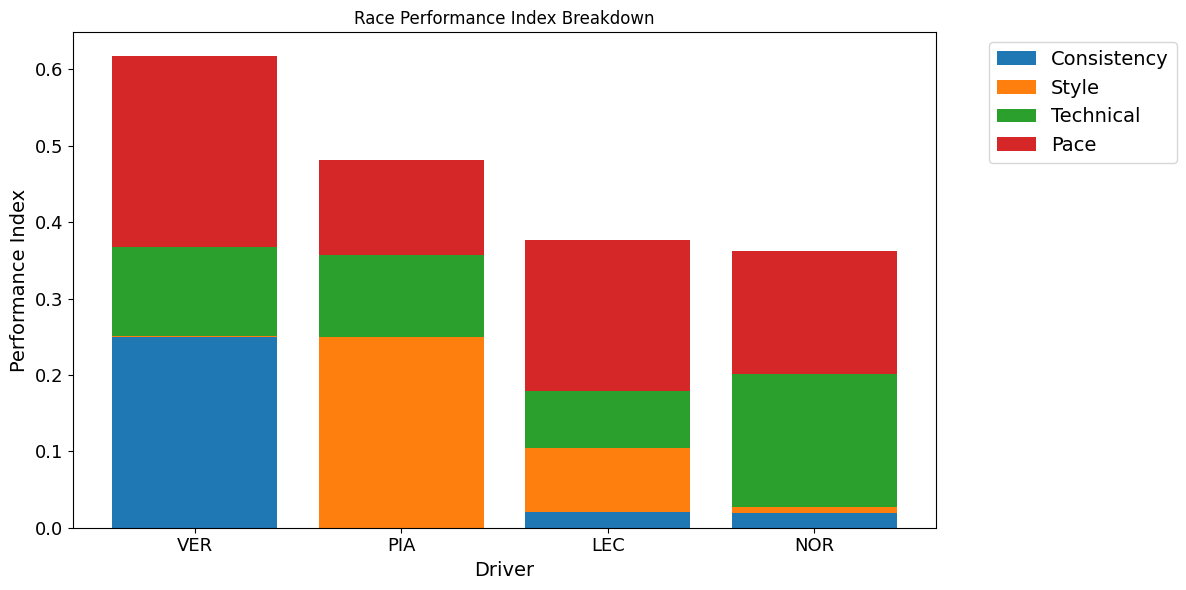

In [2]:
# Initialize the components
# Define custom cache directory
cache_dir = r"C:\Enzo_Files\AIM Data Science"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

data_processor = F1DataProcessor(cache_dir=cache_dir, year=2024)
telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

performance_analyzer = F1DriverPerformanceIndex(
    data_processor=data_processor,
    telemetry_analyzer=telemetry_analyzer,
    session_type="Race" # "Qualifying" for Qualifying race performance Data
)

performance_index = performance_analyzer.calculate_performance_index(
    rounds=range(1, 4),
    drivers=["LEC", "NOR", "PIA", "VER"]
)

perf_idx = performance_analyzer.plot_performance_breakdown(performance_index)

In [ ]:
perf_idx

,Driver,Consistency,Style,Technical,Pace,PerformanceIndex
0,VER,0.500000,0.276069,0.750000,1.000000,0.631517
3,PIA,0.500000,1.000000,0.363241,0.500000,0.590810
1,LEC,0.536615,0.264742,0.579575,0.785714,0.541662
2,NOR,0.724283,0.087377,0.677179,0.642857,0.532924


# ALL F1 DATA

SETUP Functions and Cache directory

In [2]:
# Initialize the components
# Define custom cache directory
cache_dir = r"C:\Enzo_Files\AIM Data Science"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

# --- Helper function to get all Grand Prix names efficiently ---
def get_all_grand_prix_names(year: int):
    """Quickly fetch all Grand Prix names for the given year."""
    schedule = fastf1.get_event_schedule(year)
    race_list = {
        int(row["RoundNumber"]): row["EventName"]
        for _, row in schedule.iterrows()
    }
    return race_list

def get_qualifying_and_finish_positions(year: int, rnd: int):
    """
    Returns:
        qualifying_positions (dict): {DriverAbbreviation: QualifyingPosition}
        finish_positions (dict): {DriverAbbreviation: RaceFinishPosition}
    """
    qualifying_positions = {}
    finish_positions = {}

    try:
        # --- Qualifying session ---
        qual_session = fastf1.get_session(year, rnd, 'Qualifying')
        qual_session.load()
        if not qual_session.results.empty:
            qualifying_positions = {
                row['Abbreviation']: int(row['Position'])
                for _, row in qual_session.results.iterrows()
            }

        # --- Race session ---
        race_session = fastf1.get_session(year, rnd, 'Race')
        race_session.load()
        if not race_session.results.empty:
            finish_positions = {
                row['Abbreviation']: int(row['Position'])
                for _, row in race_session.results.iterrows()
            }

    except Exception as e:
        print(f"⚠️ Could not fetch qualifying/race data for round {rnd} ({year}): {e}")

    return qualifying_positions, finish_positions




SETUP year range and drivers for performance index extraction

In [11]:

# --- Main processing loop ---
# year_list = [2022, 2023, 2024]
year_list = list(range(2020,2025))
year_list = [2023]
print(year_list)
# drivers = ["LEC", "NOR", "VER"]
# drivers =  ["HAM", "VER", "LEC", "NOR", "RUS", "ALO", "SAI", "PER", "OCO", "ALB"] # Top Drivers since 2019

# drivers = ["VER", "PER", "HAM", "RUS", "LEC", "NOR", "PIA", "ALO", "STR", "GAS", "ALB", "TSU", "BOT", "ZHO", "HUL"
# ] # 2024 Drivers

# drivers = [
#     "HAM", "VER", "LEC", "NOR", "RUS", "ALO", "SAI", "PER", "OCO", "ALB",
#     "BOT", "RIC", "GAS", "STR", "MAG", "HUL", "ZHO", "PIA", "TSU", "KVY",
#     "PAL", "ERI", "GRO", "RAI", "MSC", "LAT", "DEV", "MAZ", "KUB", "VAN"
# ]

# drivers = [
#     "HAM", "BOT", "VET", "LEC", "VER", "ALB", "SAI", "NOR",
#     "RIC", "OCO", "GAS", "KVY", "PER", "STR", "HUL", "GRO",
#     "MAG", "LAT", "KUB", "RAI"
# ] # 2020

# drivers = [
#     "HAM", "BOT", "VER", "PER", "LEC", "SAI", "NOR", "RIC",
#     "OCO", "ALO", "VET", "GAS", "ARG", "TSU", "STR", "GRO",
#     "LAT", "RAI", "MCL", "HAU", "ZHO"
# ] # 2021

# drivers = [
#     "HAM", "VER", "PER", "LEC", "SAI", "NOR", "ALO", "OCO",
#     "RUS", "TSU", "PIA", "ALB", "ZHO", "BOT", "MAG", "HUL",
#     "RIC", "STR", "KVY", "LAT"
# ] # 2022

drivers = [
    "VER", "PER", "HAM", "RUS", "LEC", "SAI", "NOR", "PIA",
    "ALO", "STR", "GAS", "OCO", "BOT", "ZHO", "MAG",
    "HUL", "ALB", "TSU"
] # 2023
print(drivers)
 

[2023]
['VER', 'PER', 'HAM', 'RUS', 'LEC', 'SAI', 'NOR', 'PIA', 'ALO', 'STR', 'GAS', 'OCO', 'BOT', 'ZHO', 'MAG', 'HUL', 'ALB', 'TSU']


RUN extraction procedure

In [12]:

# year_list = [2010]
# drivers = ["PIA"]


all_results = []  # list to collect all yearly data

for year in year_list:
    print(f"\nProcessing {year} season...")

    # Setup analyzers per year (do this ONCE)
    data_processor = F1DataProcessor(cache_dir=cache_dir, year=year)
    telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

    # Race performance analyzer
    performance_analyzer_race = F1DriverPerformanceIndex(
        data_processor=data_processor,
        telemetry_analyzer=telemetry_analyzer,
        session_type="Race"
    )

    # Qualifying performance analyzer
    performance_analyzer_qual = F1DriverPerformanceIndex(
        data_processor=data_processor,
        telemetry_analyzer=telemetry_analyzer,
        session_type="Qualifying"
    )

    gp_names = get_all_grand_prix_names(year)
    total_rounds = len(gp_names)
    print(f"Found {total_rounds} rounds in {year}")

    for rnd in range(1, total_rounds):  # change to total_rounds for full season, change to XX number to stop at a given season
        try:
            # --- Get Quali and Race Finish Positions ---
            qual_positions, finish_positions = get_qualifying_and_finish_positions(year, rnd)

            # --- Calculate Performance Metrics ---
            perf_race = performance_analyzer_race.calculate_performance_index(
                rounds=[rnd],
                drivers=drivers
            )
            perf_qual = performance_analyzer_qual.calculate_performance_index(
                rounds=[rnd],
                drivers=drivers
            )

            # Convert to DataFrames
            df_race = pd.DataFrame(perf_race)
            df_qual = pd.DataFrame(perf_qual)

            # Add suffixes to distinguish them
            df_race = df_race.add_suffix("_Race")
            df_qual = df_qual.add_suffix("_Qual")

            # Merge on driver abbreviations
            merged = pd.merge(
                df_race, df_qual,
                left_on="Driver_Race", right_on="Driver_Qual", how="outer"
            )

            # Add metadata
            merged["GrandPrix"] = gp_names.get(rnd, "Unknown GP")
            merged["Round"] = rnd
            merged["Year"] = year
            merged["QualifyingPosition"] = merged["Driver_Race"].map(qual_positions)
            merged["RaceFinishPosition"] = merged["Driver_Race"].map(finish_positions)

            # Arrange columns
            merged = merged[
                [
                    "Driver_Race", 
                    "Consistency_Race", "Style_Race", "Technical_Race", "Pace_Race", "PerformanceIndex_Race",
                    "Consistency_Qual", "Style_Qual", "Technical_Qual", "Pace_Qual", "PerformanceIndex_Qual",
                    "GrandPrix", "Round", "Year", 
                    "QualifyingPosition", "RaceFinishPosition"
                ]
            ]

            all_results.append(merged)
            print(f"✅ Completed Round {rnd} ({gp_names.get(rnd)}) for {year}")

        except Exception as e:
            print(f"⚠️ Skipping Round {rnd} ({year}) due to error: {e}")




Processing 2023 season...
Found 23 rounds in 2023
Number of components needed for 95.0% variance: 176

Driver Centroids (average position in PCA space):
             PC1       PC2        PC3        PC4       PC5       PC6  \
Driver                                                                 
ALB     0.972146 -2.513015   0.069383  -1.825904 -0.885602 -3.550755   
ALO     2.270532  0.303053   1.378631  -0.777605  0.883294 -0.264565   
BOT     0.393027 -2.321541   1.083876  -2.270051  0.130043 -2.556495   
GAS    -0.374714  0.198186  -2.131828   5.765988 -2.724538  2.766812   
HAM     3.831845  2.691787   1.528874   0.512949  1.076760 -3.098103   
HUL    -0.746039  0.188082  -0.015123  -0.943588  0.729654  1.300544   
LEC     0.730170  0.074612   1.598437  -3.054642  1.635029 -0.394238   
MAG    -0.542032 -1.563014   0.318940  -2.405308 -0.548570 -0.094593   
NOR    -5.799418  2.096463  -0.503198  -1.373734  1.046657  4.627231   
OCO    -6.954930  1.624862  -2.924757  -0.586593 -2.09

core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.


Number of components needed for 95.0% variance: 180

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
ALB    -8.295985  4.043595 -2.565984 -4.214597  3.486819  1.892091  1.105456   
ALO     6.046674 -0.431602  2.804614  0.290592 -1.892729  2.873101  1.008179   
BOT    -2.437846 -2.864748  0.385470  1.488532 -0.321581 -0.158704 -0.472061   
GAS    -3.430207 -0.017287 -2.413657  1.158240 -0.501746 -1.311431 -1.078141   
HAM     6.196961 -0.007519  3.134099  0.021701 -0.713316  1.008595  1.455427   
HUL    -2.848689  0.939595 -1.437888 -1.024921 -0.427846  0.372310  0.665075   
LEC     0.940916 -2.146073  1.256549  0.483397  0.445357  0.383417  1.180368   
MAG    -3.047997  2.646914 -2.715394 -0.774156  0.397677  1.098362  0.049355   
NOR    -3.057687  2.721869 -4.581124 -2.804199  5.906886  0.801086 -1.838211   
OCO    -2.490409 

core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.


Number of components needed for 95.0% variance: 186

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
ALB     0.290315 -0.951436  0.488271  0.088901 -1.913807  1.783762 -0.657033   
ALO     1.569517 -1.383544  0.220436  0.323827 -1.377157  0.575691 -0.565498   
BOT    -1.966552 -1.318161 -0.484392 -2.282520  0.271677 -0.796123  0.199770   
GAS    -0.981638 -0.655609 -0.716164 -0.718317  3.784079 -2.119709  1.969237   
HAM     2.429394  0.085498  1.178190  0.742034 -3.108917  2.501486 -1.118883   
HUL    -0.065896  2.884281  0.136992  1.017220 -0.137417 -0.368729 -0.294054   
LEC     0.253865  1.148376  0.592624  0.473447  2.205274 -2.246233  1.928501   
MAG    -1.185760  1.581356 -0.436241 -0.391803  3.238429 -0.340113  1.612477   
NOR    -0.762507 -0.282298 -1.212060  0.269171  1.680830 -1.216098 -0.994686   
OCO    -0.848630 

core        WARNING 	Fixed incorrect tyre stint information for driver '22'
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
core        WARNING 	Fixed incorrect tyre stint information for driver '22'


Number of components needed for 95.0% variance: 157

Driver Centroids (average position in PCA space):
             PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                          
ALB     1.651944   2.591918 -1.537656 -1.288687 -1.315611 -0.480063  0.322341   
ALO     1.086144  -3.776500  0.261322 -0.404869  1.040062 -0.783300 -0.284719   
BOT     1.088107   0.558623  0.182390 -0.432820 -0.044529  0.414280  0.217708   
GAS    -2.248231   2.497089  3.003623  0.144074  0.854131 -1.094497  0.411077   
HAM     1.644519  -8.750532 -2.533467 -0.269187  0.412590  0.934836 -1.126547   
HUL    -0.725421   0.335487 -1.217270  0.927383 -0.735097 -0.890705  0.692394   
LEC     0.352551  -4.382452 -1.512584 -0.449219  1.064404  0.835926 -0.886877   
MAG    -1.606827   1.457272 -0.363571  0.592797  0.142710  1.022702  0.076504   
NOR     0.111146  10.325464  4.778125  0.504289  0.153722 -1.114332  0.662776   
OCO   

_api        WARNING 	Driver 20: Encountered 1 timing integrity error(s) near lap(s): [34].
This might be a bug and should be reported.
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!


Number of components needed for 95.0% variance: 160

Driver Centroids (average position in PCA space):
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                          
ALB      1.270368  0.553136 -0.579271 -1.011885 -1.209797  1.062253  0.024763   
ALO      1.921216 -0.204182  1.462714 -4.263916 -2.714428  0.273589 -0.183022   
BOT     -0.612479  2.802116 -0.939110  1.744460  0.242368 -0.609298  0.248694   
GAS     -1.519464 -4.100994 -0.473098 -1.142636  0.183236 -0.187449  0.767374   
HAM      2.310238  2.416016  0.735992 -1.147902 -0.575860  0.601267 -0.505661   
HUL    -21.741074  7.620432 -5.210890  0.951500  0.148594  0.641890 -0.213088   
LEC      1.848392 -1.849868  2.246102 -4.359364 -3.226423 -0.473948  0.197191   
MAG      0.323411  0.033559 -0.598961  2.399625 -0.623549 -0.658684 -0.749108   
NOR      1.127732  0.785727 -1.606208  3.376795  2.846751 -0.231565  0.006975   
OCO   

_api        WARNING 	Driver  3: Car data is incomplete!
_api        WARNING 	Driver  5: Car data is incomplete!
_api        WARNING 	Driver  6: Car data is incomplete!
_api        WARNING 	Driver  7: Car data is incomplete!
_api        WARNING 	Driver  8: Car data is incomplete!
_api        WARNING 	Driver  9: Car data is incomplete!
_api        WARNING 	Driver 12: Car data is incomplete!
_api        WARNING 	Driver 15: Car data is incomplete!
_api        WARNING 	Driver 17: Car data is incomplete!
_api        WARNING 	Driver 19: Car data is incomplete!
_api        WARNING 	Driver 25: Car data is incomplete!
_api        WARNING 	Driver 26: Car data is incomplete!
_api        WARNING 	Driver 28: Car data is incomplete!
_api        WARNING 	Driver 29: Car data is incomplete!
_api        WARNING 	Driver 30: Car data is incomplete!
_api        WARNING 	Driver 44: Car data is incomplete!
_api        WARNING 	Driver 55: Car data is incomplete!
_api        WARNING 	Driver 63: Car data is inco

Number of components needed for 95.0% variance: 164

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
ALB     0.061828 -0.907000 -0.682722  0.653252  0.103659 -0.349349 -0.168106   
ALO     0.401473  0.108828 -0.038477 -2.416054  0.857054 -1.130062 -0.305081   
BOT    -0.712764  1.857408 -0.326461 -1.144324  1.250547  0.141196  0.451289   
GAS    -4.036277 -4.497633 -1.220460  9.090097 -2.954171 -0.068922  0.935804   
HAM     2.652579 -1.176302  0.501662 -2.272009 -0.901288 -0.304750 -0.115321   
HUL    -0.499057  0.771442 -0.592887  0.644005 -0.298317  0.960236 -1.181365   
LEC    -0.200562  1.468687  0.275967  0.126581 -0.323835  0.877323  0.398947   
MAG     6.710397  1.994221  0.437363  0.993147  1.166471  0.018044  2.509585   
NOR     1.903861  2.561492 -0.764894 -2.120159  1.914762 -0.756402  0.034421   
OCO     0.168480 

_api        WARNING 	Failed to align laps for drivers: ['31', '10']


⚠️ Skipping Round 11 (2023) due to error: 'GAS'
⚠️ Skipping Round 12 (2023) due to error: 'PIA'


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.


Number of components needed for 95.0% variance: 176

Driver Centroids (average position in PCA space):
             PC1       PC2        PC3       PC4       PC5       PC6       PC7  \
Driver                                                                          
ALB     0.846505 -0.841908  -1.695076 -1.602305  0.306460 -1.226672  0.836876   
ALO     0.813579  0.000297  -0.602403  0.677085 -1.272922 -1.750243 -0.716331   
BOT     0.184412  0.321146  -1.205182 -0.973353  0.437658  3.054840 -0.297253   
GAS    -0.351519  0.449779  -2.006541 -0.357370 -0.173296 -1.015624 -1.250049   
HAM     1.992466  1.965108  -1.656575 -1.373419  1.823189  4.379403 -1.064020   
HUL     0.316134 -0.977104  -0.756511 -0.417516 -0.846578 -0.668850  0.429898   
LEC    -2.742741  0.508018  -1.904285 -1.471370 -1.773360  0.431895 -0.041825   
MAG    -1.256445  1.072446  -1.014415  0.157027 -1.596425 -2.240701 -0.718837   
NOR     0.601272  0.625440  -1.457962 -2.115053  3.517370  4.565899 -0.058479   
OCO   

core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WARNING 	Driver 55 completed the race distance 06:14.695000 before the recorded end of the session.
core        WARNING 	Driver 16 completed the race distance 06:14.511000 before the recorded end of the session.
core        WARNING 	Driver 63 completed the race distance 06:07.860000 before the recorded end of the session.
core        WARNING 	Driver 44 completed the race distance 05:48.209000 before the recorded end of the session.
core        WARNING 	Driver 23 completed the race distance 05:40.782000 before the recorded end of the session.
core        WARNING 	Driver 4 completed the race distance 05:40.439000 before the recorded end of the session.
core        WARNING 	Driver 14 completed the race distance 05:39.594000 before the recorded end of the ses

⚠️ Skipping Round 14 (2023) due to error: 'TSU'


core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!


⚠️ Could not fetch qualifying/race data for round 15 (2023): cannot convert float NaN to integer


core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)


⚠️ Skipping Round 15 (2023) due to error: 'STR'


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.


Number of components needed for 95.0% variance: 156

Driver Centroids (average position in PCA space):
              PC1        PC2       PC3       PC4        PC5        PC6  \
Driver                                                                   
ALB     -7.489689  -1.479458 -1.813317 -3.135102  -2.813708  -0.109048   
ALO      1.359116   0.104333  1.089578  0.400498   1.888241   0.896150   
BOT    -63.634120 -25.451800  0.977531  1.298617 -12.853818   1.060494   
GAS     -1.474465   1.055750  0.431887 -1.073695   0.080631   1.177655   
HAM      3.229407   0.003172  0.668395  0.835822  -0.375046   1.336077   
HUL     -0.340971   1.919883  0.554833  0.029960  -0.173690  -2.122780   
LEC      2.461048   0.033578  0.508956  1.180510   0.503542  -1.303021   
MAG      0.535594   2.063259 -3.136233 -1.342675  -0.681268  -1.156557   
NOR      2.358972  -0.781255  0.484647  0.710262   1.303615  -1.254471   
OCO     -1.890891  -0.329761  0.512494 -0.679924  -0.629338   2.394317   
PER    -2

core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)


⚠️ Skipping Round 17 (2023) due to error: 'HAM'


logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to add first lap time from Ergast!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to add first lap time from Ergast!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!


Error processing race round 18: The data you are trying to access has not been loaded yet. See `Session.load`
⚠️ Skipping Round 18 (2023) due to error: cannot unpack non-iterable NoneType object


logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	

Error processing race round 19: The data you are trying to access has not been loaded yet. See `Session.load`
⚠️ Skipping Round 19 (2023) due to error: cannot unpack non-iterable NoneType object


logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	

Error processing race round 20: The data you are trying to access has not been loaded yet. See `Session.load`
⚠️ Skipping Round 20 (2023) due to error: cannot unpack non-iterable NoneType object


logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	

Error processing race round 21: The data you are trying to access has not been loaded yet. See `Session.load`
⚠️ Skipping Round 21 (2023) due to error: cannot unpack non-iterable NoneType object


logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	

Error processing race round 22: The data you are trying to access has not been loaded yet. See `Session.load`
⚠️ Skipping Round 22 (2023) due to error: cannot unpack non-iterable NoneType object


In [13]:
# --- Combine everything into one DataFrame ---
performance_df = pd.concat(all_results, ignore_index=True)

print("\nFinal Combined DataFrame:")
print(performance_df.head())



Final Combined DataFrame:
  Driver_Race  Consistency_Race  Style_Race  Technical_Race  Pace_Race  \
0         ALB          0.743987    0.251098        0.607627   0.763158   
1         ALO          0.822705    0.395674        0.375566   0.947368   
2         BOT          0.881331    0.416357        0.297360   0.815789   
3         GAS          0.678069    0.477269        0.307608   0.789474   
4         HAM          0.839532    0.520116        0.161241   0.894737   

   PerformanceIndex_Race  Consistency_Qual  Style_Qual  Technical_Qual  \
0               0.591467          0.982745    0.543192        0.474406   
1               0.635328          0.984977    0.236451        0.501484   
2               0.602709          0.987548    0.197724        0.418276   
3               0.563105          0.990491    0.442103        0.539274   
4               0.603907          0.974712    0.251306        0.215185   

   Pace_Qual  PerformanceIndex_Qual           GrandPrix  Round  Year  \
0   0.63157

### CODE TEMPLATE for Team to Run

In [ ]:
from core.extract import F1DataProcessor
from core.telemetry import F1TelemetryAnalyzer
from core.dpi import F1DriverPerformanceIndex
from core.utils import plot_combined_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import fastf1
import pandas as pd
import os
from datetime import datetime

# %load_ext autoreload
# %autoreload 2

# Initialize the components
# Define custom cache directory
cache_dir = r"C:"

# Create it if not already existing
os.makedirs(cache_dir, exist_ok=True)

# Enable FastF1 cache at that location
fastf1.Cache.enable_cache(cache_dir)

# --- Helper function to get all Grand Prix names efficiently ---
def get_all_grand_prix_names(year: int):
    """Quickly fetch all Grand Prix names for the given year."""
    schedule = fastf1.get_event_schedule(year)
    race_list = {
        int(row["RoundNumber"]): row["EventName"]
        for _, row in schedule.iterrows()
    }
    return race_list

def get_qualifying_and_finish_positions(year: int, rnd: int):
    """
    Returns:
        qualifying_positions (dict): {DriverAbbreviation: QualifyingPosition}
        finish_positions (dict): {DriverAbbreviation: RaceFinishPosition}
    """
    qualifying_positions = {}
    finish_positions = {}

    try:
        # --- Qualifying session ---
        qual_session = fastf1.get_session(year, rnd, 'Qualifying')
        qual_session.load()
        if not qual_session.results.empty:
            qualifying_positions = {
                row['Abbreviation']: int(row['Position'])
                for _, row in qual_session.results.iterrows()
            }

        # --- Race session ---
        race_session = fastf1.get_session(year, rnd, 'Race')
        race_session.load()
        if not race_session.results.empty:
            finish_positions = {
                row['Abbreviation']: int(row['Position'])
                for _, row in race_session.results.iterrows()
            }

    except Exception as e:
        print(f"⚠️ Could not fetch qualifying/race data for round {rnd} ({year}): {e}")

    return qualifying_positions, finish_positions


def get_drivers_for_year(year):
    """
    Returns a list of driver 3-letter codes who raced during a given F1 season.
    Uses the Race session entry list for each round.
    """
    print(f"Fetching driver list for {year}...")
    schedule = fastf1.get_event_schedule(year)
    drivers_in_year = set()

    for rnd in schedule.index:
        try:
            session = fastf1.get_session(year, rnd, 'R')  # R = Race
            session.load()  # loads session metadata and results
            drivers_in_year.update(session.drivers)  # add all drivers from that race
        except Exception as e:
            print(f"⚠️ Could not load round {rnd} ({schedule.loc[rnd, 'EventName']}): {e}")

    return sorted(list(drivers_in_year))



# --- Main processing loop ---
# year_list = [2022, 2023, 2024]
year_list = list(range(2020,2025))
# year_list = [2024]
# print(year_list)
# drivers = ["LEC", "NOR", "VER"]
drivers =  ["HAM", "VER", "LEC", "NOR", "RUS", "ALO", "SAI", "PER", "OCO", "ALB"] # Top Drivers since 2019
# drivers = [
#     "HAM", "VER", "LEC", "NOR", "RUS", "ALO", "SAI", "PER", "OCO", "ALB",
#     "BOT", "RIC", "GAS", "STR", "MAG", "HUL", "ZHO", "PIA", "TSU", "KVY",
#     "PAL", "ERI", "GRO", "RAI", "MSC", "LAT", "DEV", "MAZ", "KUB", "VAN"
# ]
# for year in year_list:
#     # Get only drivers who actually raced that season
#     drivers = get_drivers_for_year(year)
#     print(f"✅ {year}: {len(drivers)} drivers -> {drivers}")


# year_list = [2010]
# drivers = ["PIA"]


all_results = []  # list to collect all yearly data

for year in year_list:
    print(f"\nProcessing {year} season...")

    # Setup analyzers per year (do this ONCE)
    data_processor = F1DataProcessor(cache_dir=cache_dir, year=year)
    telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

    # Race performance analyzer
    performance_analyzer_race = F1DriverPerformanceIndex(
        data_processor=data_processor,
        telemetry_analyzer=telemetry_analyzer,
        session_type="Race"
    )

    # Qualifying performance analyzer
    performance_analyzer_qual = F1DriverPerformanceIndex(
        data_processor=data_processor,
        telemetry_analyzer=telemetry_analyzer,
        session_type="Qualifying"
    )

    gp_names = get_all_grand_prix_names(year)
    total_rounds = len(gp_names)
    print(f"Found {total_rounds} rounds in {year}")

    for rnd in range(1, 5):  # change to total_rounds for full season
        try:
            # --- Get Quali and Race Finish Positions ---
            qual_positions, finish_positions = get_qualifying_and_finish_positions(year, rnd)

            # --- Calculate Performance Metrics ---
            perf_race = performance_analyzer_race.calculate_performance_index(
                rounds=[rnd],
                drivers=drivers
            )
            perf_qual = performance_analyzer_qual.calculate_performance_index(
                rounds=[rnd],
                drivers=drivers
            )

            # Convert to DataFrames
            df_race = pd.DataFrame(perf_race)
            df_qual = pd.DataFrame(perf_qual)

            # Add suffixes to distinguish them
            df_race = df_race.add_suffix("_Race")
            df_qual = df_qual.add_suffix("_Qual")

            # Merge on driver abbreviations
            merged = pd.merge(
                df_race, df_qual,
                left_on="Driver_Race", right_on="Driver_Qual", how="outer"
            )

            # Add metadata
            merged["GrandPrix"] = gp_names.get(rnd, "Unknown GP")
            merged["Round"] = rnd
            merged["Year"] = year
            merged["QualifyingPosition"] = merged["Driver_Race"].map(qual_positions)
            merged["RaceFinishPosition"] = merged["Driver_Race"].map(finish_positions)

            # Arrange columns
            merged = merged[
                [
                    "Driver_Race", 
                    "Consistency_Race", "Style_Race", "Technical_Race", "Pace_Race", "PerformanceIndex_Race",
                    "Consistency_Qual", "Style_Qual", "Technical_Qual", "Pace_Qual", "PerformanceIndex_Qual",
                    "GrandPrix", "Round", "Year", 
                    "QualifyingPosition", "RaceFinishPosition"
                ]
            ]

            all_results.append(merged)
            print(f"✅ Completed Round {rnd} ({gp_names.get(rnd)}) for {year}")

        except Exception as e:
            print(f"⚠️ Skipping Round {rnd} ({year}) due to error: {e}")


# --- Combine everything into one DataFrame ---
performance_df = pd.concat(all_results, ignore_index=True)

print("\nFinal Combined DataFrame:")
print(performance_df.head())

# --- Define output path ---
output_dir = os.path.join(cache_dir, "exports")  # example: save in a subfolder
os.makedirs(output_dir, exist_ok=True)

# Optional: include timestamp to avoid overwriting
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = os.path.join(output_dir, f"performance_results_{timestamp}.csv")

# --- Write to CSV ---
performance_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n💾 CSV saved successfully to:\n{output_file}")